In [1]:
# load aruco_config and do aruco_detection
import os
from tqdm import tqdm
from umi.common.cv_util import (
    parse_aruco_config, 
    parse_fisheye_intrinsics,
    convert_fisheye_intrinsics_resolution,
    detect_localize_aruco_tags,
    draw_predefined_mask
)
import yaml
import json
import av 
import numpy as np

In [2]:
root_dir = "/home/ubuntu"
aruco_config_path = os.path.join(root_dir, "universal_manipulation_interface/example/calibration/aruco_config.yaml")
intrinsics_path = os.path.join(root_dir, "universal_manipulation_interface/example/calibration/gopro_intrinsics_2_7k.json")

In [3]:
input_video_path = os.path.join(root_dir, "example_demo_session/demos/mapping/raw_video.mp4")

In [4]:
# load aruco config
aruco_config = parse_aruco_config(yaml.safe_load(open(aruco_config_path, 'r')))
aruco_dict = aruco_config['aruco_dict']
marker_size_map = aruco_config['marker_size_map']
# load intrinsics
raw_fisheye_intr = parse_fisheye_intrinsics(json.load(open(intrinsics_path, 'r')))

In [5]:
in_container = av.open(input_video_path)
in_stream = in_container.streams.video[0]
in_res = np.array([in_stream.height, in_stream.width])[::-1]
fisheye_intr = convert_fisheye_intrinsics_resolution(
            opencv_intr_dict=raw_fisheye_intr, target_resolution=in_res)

In [7]:
results = []
imgs = []
for i, frame in tqdm(enumerate(in_container.decode(in_stream)), total=in_stream.frames):
    img = frame.to_ndarray(format='rgb24')
    frame_cts_sec = frame.pts * in_stream.time_base
    # avoid detecting tags in the mirror
    img = draw_predefined_mask(img, color=(0,0,0), mirror=True, gripper=False, finger=False)
    tag_dict = detect_localize_aruco_tags(
        img=img,
        aruco_dict=aruco_dict,
        marker_size_map=marker_size_map,
        fisheye_intr_dict=fisheye_intr,
        refine_subpix=True
    )
    result = {
        'frame_idx': i,
        'time': float(frame_cts_sec),
        'tag_dict': tag_dict
    }
    results.append(result)
    imgs.append(img)

100%|██████████| 3311/3311 [06:54<00:00,  7.99it/s]


In [17]:
# One can use the corners to plot visualization; Can you plot a several video, showing the coordinates of the corners? In camera coordinates.
import cv2
new_images = []
colors = [
    (255, 0, 0),
    (0, 255, 0),
    (0, 0, 255),
    (255, 255, 0),
    (255, 0, 255),
    (0, 255, 255),
]
count = 0
for img, result in zip(imgs, results):
    for c, (tag_id, tag_info) in zip(colors, result['tag_dict'].items()):
        corners = tag_info['corners']
        for corner in corners:
            # cv2.circle(img, tuple(corner), 5, (0, 0, 255), -1)
            cv2.circle(img, tuple([int(corner[0]), int(corner[1])]), 20, c, -1)
    new_images.append(img)
    count += 1
    if count > 5:
        break

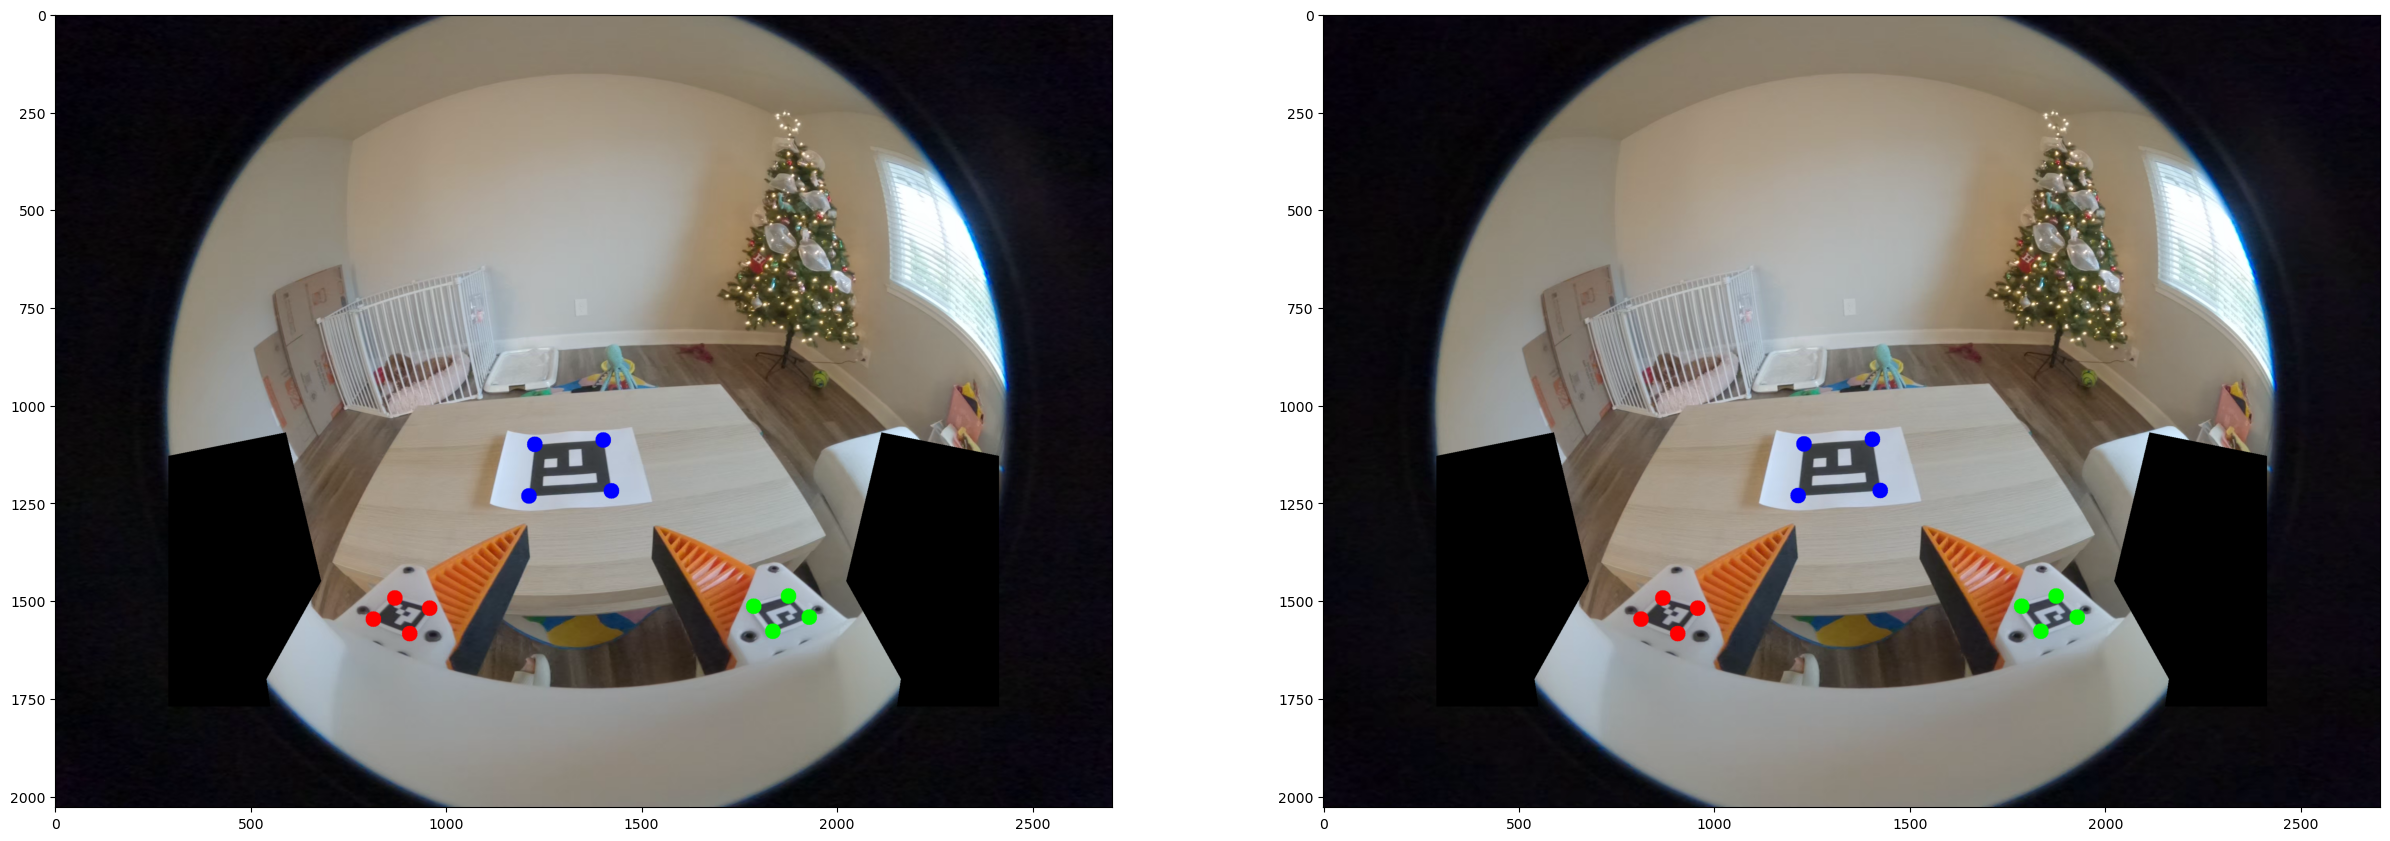

In [20]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30, 30))
for ii in range(2):
    ax = fig.add_subplot(1, 2, ii + 1) 
    ax.imshow(new_images[ii])
    